(self-attention)=
# A First Look at Self-Attention

Consider the following review:

> **“The movie was *not* good, but the soundtrack was amazing.”**

A simple bag-of-words classifier will see both *good* and *amazing* (positive) and probably predict a positive sentiment, missing the negation “not.”  

Self-attention can discover that "not" modifies "good" while leaving "amazing" untouched.

The first step is to tokenize the sentence: 
| position | token |
|:-------:|-------|
| 0 | The |
| 1 | movie |
| 2 | was |
| 3 | **not** |
| 4 | **good** |
| 5 | , |
| 6 | but |
| 7 | the |
| 8 | soundtrack |
| 9 | was |
|10 | **amazing** |
|11 | . |

Each token is mapped to a small vector (embedding). The exact numbers are not important; they are learned during training.  In fact, a **positional embedding** is used to also indicate its position in the sentence.

## Computing attention scores (conceptually)

Focus on the token at position 4, **“good.”**  We want to compute how much attention it should pay to all other tokens in the sentence.  To find this, we do the following:

1. **Query and key vectors**: For each token, we compute three vectors: a **query** $q_i$ and a **key** $k_j$.  These are obtained by multiplying the embedding with learned weight matrices $W^Q$ and $W^K$.  The **value** vector $v_j$ is also computed, but it is not used to compute the attention scores.   

2. **Dot product**: For the token at position 4, we compute the **dot product** of its query $q_{good}$ with all keys $k_j$ in the sentence.  This gives us a score for each token, indicating how relevant it is to the token at position 4.  Larger dot products mean higher relevance.  Then, after scaling and the applying softmax, we obtain a **weight** for each other token:

      | key token $j$ | weight $w_{4j}$ |
      |-----------------|-------------------|
      | The             | 0.01 |
      | movie           | 0.02 |
      | was (1st)       | 0.03 |
      | **not**         | **0.55** |
      | **good**        | 0.10 |
      | ,               | 0.02 |
      | but             | 0.05 |
      | the             | 0.02 |
      | soundtrack      | 0.03 |
      | was (2nd)       | 0.05 |
      | amazing         | 0.11 |
      | .               | 0.01 |

      In this example, the model assigns more than half of the total weight to “not,” capturing the local negation, and a moderate share to “amazing,” which influences the overall sentiment.

3. **Weighted sum of value vectors**: In addition to query and key vectors, we also compute a **value vector** $v_j$.   Finally, we compute a weighted sum of the value vectors $v_j$ using the weights $w_{4j}$:
      $$
      \text{output}(\text{good})
            =\sum_{j=0}^{11} w_{4j}\,v_j .
      $$

      Because $w_{4,3}=0.55$ is large, the output vector encodes that **“good” is negated**.  

Later layers (or a classifier head) can use this context-rich vector to predict a negative contribution from *“not good,”* while recognising the strong positive signal from *“amazing.”*

## Summary
* **Context matters.** Self-attention lets every token look at the entire sentence, so “not” can influence “good.”  
* **Parallel computation.** Unlike an RNN, all tokens are processed at once, which is faster and handles long sentences gracefully.  
* **Dynamic meaning.** The same word can mean something different in another sentence; the attention pattern adapts.


## Quick refresher on the **dot product**

For two vectors $\mathbf a, \mathbf b \in \mathbb R^{d}$ with  
$\mathbf a = (a_1,\dots,a_d)$ and $\mathbf b = (b_1,\dots,b_d)$, the the **dot product** is defined as:

$$
\mathbf a \cdot \mathbf b \;=\; \sum_{k=1}^{d} a_k\,b_k .
$$


For example, consider the two vectors:  

`a = [2, 3]`  
`b = [5, −1]`  

To find the dot product, we multiply the corresponding elements and sum them up:

`a · b = 2·5 + 3·(−1) = 10 − 3 = 7`

### Geometric view  

$$
\mathbf a \cdot \mathbf b
=\lVert\mathbf a\rVert \,\lVert\mathbf b\rVert \,\cos\theta,
$$

where $\theta$ is the angle between the vectors.

| angle $\theta$ | $\cos\theta$ | sign / size of $\mathbf a\!\cdot\!\mathbf b$ | geometric relation |
|:---:|:---:|:---:|:---|
| $0^\circ$   | $+1$ | largest positive | vectors point the **same** way |
| $90^\circ$  | $0$  | zero             | vectors are **orthogonal** |
| $180^\circ$ | $-1$ | negative         | vectors point **opposite** ways |

A high positive dot product implies that vectors are long **and** almost parallel.  A zero dot product implies that the vectors are orthogonal (perpendicular).  A negative dot product implies that the vectors are long **and** almost opposite.
 

###  Why dot products drive self-attention  

* **Query** $q_i$ = direction token *i* is “looking”  
* **Key**   $k_j$ = direction of token *j*’s features  
* **Score** $s_{i,j}=q_i\!\cdot k_j$

Large $s_{i,j}$ implies a small angle between the vectors which implies that token *j* matches what token *i* wants.  


In [3]:
import numpy as np

q_good = np.array([0, 1])      # query for "good"
k_good = np.array([0, 1])      # key   for "good"
k_not  = np.array([0.5, 0.5])  # key   for "not"
k_the  = np.array([0,  0])     # key   for "The"

scores = np.array([
    q_good @ k_good,   # 1.0
    q_good @ k_not,    # 0.5
    q_good @ k_the     # 0.0
])

scores /= np.sqrt(2)   
weights = np.exp(scores) / np.exp(scores).sum()

print("Weights from 'good' → good, not, The")
print(np.round(weights, 2))


Weights from 'good' → good, not, The
[0.46 0.32 0.22]


### Query **Q**, Key **K**, and Value **V** Matrices

Suppose that $n$ is the sequence length, $d_{\text{model}}$ is the embedding dimension, and $d_k$ is the dimension of the query, key and value vectors. 

* $n$ is the number of tokens in the input sequence after truncation and padding.  
* $d_{\text{model}}$ is the size of the embedding vector for each token.  
* $d_k$ is the size of the query, key, and value vectors.  The model keeps three learned weight matrices $W_Q$, $W_K$, and $W_V$ of size $d_{\text{model}} \times d_k$.

Let $X \in \mathbb{R}^{n \times d_{\text{model}}}$ be the matrix whose rows are the token-embedding vectors after positional encoding  

$$
\bigl[x_1^{\top};\,x_2^{\top};\,\dots;\,x_n^{\top}\bigr].
$$

For **each attention head** $h$ the model keeps three learned weight matrices  

$$
W_Q,\; W_K,\; W_V \in \mathbb{R}^{d_{\text{model}}\times d_k}.
$$

Multiplying the embedding matrix by those weights yields  

$$
Q  \;=\; X\,W_Q, \qquad
K  \;=\; X\,W_K, \qquad
V  \;=\; X\,W_V.
$$

The shape of each of $Q, K, V$ is $n \times d_k$ (one $d_k$-dimensional row per token).
The rows $q_i,\;k_i,\;v_i$ are the *query*, *key*, and *value* vectors for token $i$.

| Symbol |   Intuitive meaning |
|--------|---------------------------------|
| $q_i$  | "What does **this** token need or look for?" |
| $k_j$  | "What attributes does token *j* offer to others?" |
| $v_j$  | "The information token *j* will contribute if it is attended to." |


In [4]:
import numpy as np

# ---------------------------------------------------------------------
# 1) Token list – indices are handy for debugging
# ---------------------------------------------------------------------
tokens = ["The", "movie", "was", "not", "good", ",", "but",
          "the", "soundtrack", "was", "amazing", "."]

n_tokens, d = len(tokens), 2                # d_model = 2
Q = np.zeros((n_tokens, d))
K = np.zeros((n_tokens, d))
V = np.zeros((n_tokens, d))

# ---------------------------------------------------------------------
# 2) Hand-crafted vectors for the three special words
# ---------------------------------------------------------------------
special_qk = {3: [20, 20],      # “not”
              4: [0, 1],      # “good”
             10: [19, 19]}      # “amazing”

special_v  = {3: [1, 0],
              4: [0, 1],
             10: [1, 1]}

for idx, vec in special_qk.items():
    Q[idx] = K[idx] = vec

for idx, vec in special_v.items():
    V[idx] = vec

# ---------------------------------------------------------------------
# 3) Scaled dot-product attention  (decoder style → add causal mask)
# ---------------------------------------------------------------------
scores = Q @ K.T                           # (n_tokens × n_tokens)
scores /= np.sqrt(d)                       # scale by √d_k

# ---- causal (look-ahead) mask ----
#mask = np.triu(np.ones_like(scores, dtype=bool), k=1)  # j > i region
#scores[mask] = -1e9                      # −∞ ⇒ 0 after softmax

# Softmax row by row
exp_scores = np.exp(scores)
weights = exp_scores / exp_scores.sum(axis=-1, keepdims=True)

# ---------------------------------------------------------------------
# 4) Attention output = weights · V
# ---------------------------------------------------------------------
outputs = weights @ V                      # (n_tokens × d)

# ---------------------------------------------------------------------
# 5) Inspect the row that corresponds to the *query* word “good”
# ---------------------------------------------------------------------
idx_good = 4
print(f"\nMasked attention weights FROM ‘{tokens[idx_good]}’ (index {idx_good})")
for j, w in enumerate(weights[idx_good]):
    print(f"  → {tokens[j]:<11s}  w = {w:.2f}")

print("\nResulting context vector for 'good':", outputs[idx_good])



Masked attention weights FROM ‘good’ (index 4)
  → The          w = 0.00
  → movie        w = 0.00
  → was          w = 0.00
  → not          w = 0.67
  → good         w = 0.00
  → ,            w = 0.00
  → but          w = 0.00
  → the          w = 0.00
  → soundtrack   w = 0.00
  → was          w = 0.00
  → amazing      w = 0.33
  → .            w = 0.00

Resulting context vector for 'good': [0.99999467 0.33023767]


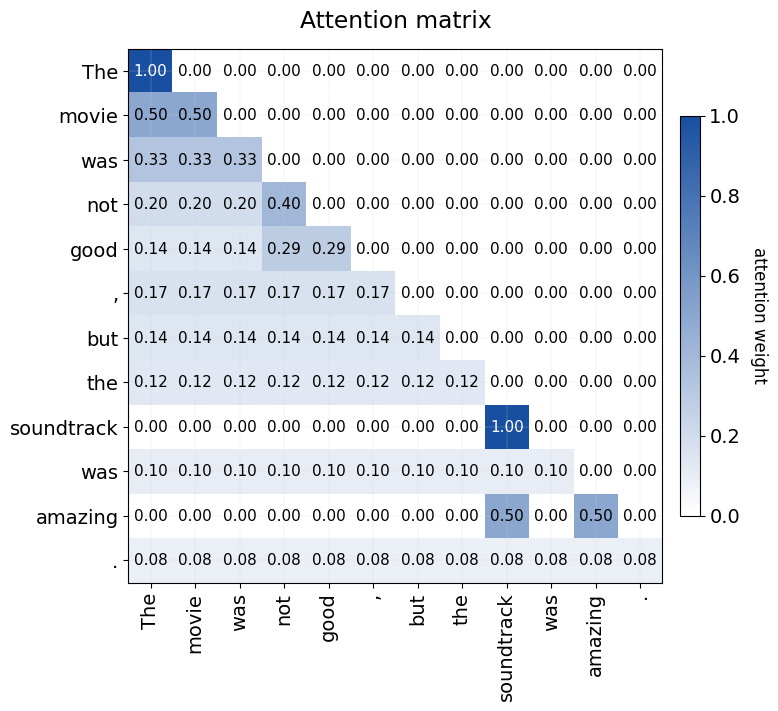

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# --------------------------------------------------------------------
# 1) Sentence tokens and tiny hand-crafted projections
# --------------------------------------------------------------------
tokens = [
    "The", "movie", "was", "not", "good", ",", "but",
    "the", "soundtrack", "was", "amazing", "."
]
n, d = len(tokens), 2           # d_model = d_k = 2  (tiny for clarity)

# Hand-crafted query/key vectors for three important words
special_qk = {
     3: [0, 1],   # "not"
     4: [ 0,  1],   # "good"
    8: [19, 19],   # "soundtrack"
    10: [19, 19]    # "amazing"
}

# Hand-crafted value vectors (not used for the heat-map itself)
special_v = {
     3: [-1, 0], # not
     4: [0, 1],  # good
    8: [1, 1],   # amazing
    10: [1, 1]   # amazing
}

# --------------------------------------------------------------------
# 2) Build Q, K and compute the masked attention weights
# --------------------------------------------------------------------
def build_QK():
    Q = np.zeros((n, d))
    K = np.zeros((n, d))
    for idx, vec in special_qk.items():
        Q[idx] = K[idx] = vec
    return Q, K

def attention_with_causal_mask():
    Q, K = build_QK()
    scores = (Q @ K.T) / np.sqrt(d)                # scaled dot products
    # causal mask = forbid future tokens (j > i)
    future = np.triu(np.ones_like(scores, dtype=bool), k=1)
    scores[future] = -1e9                          # -∞ so softmax → 0
    exp_s = np.exp(scores)
    W = exp_s / exp_s.sum(axis=-1, keepdims=True)  # row-softmax
    return W

W_mask = attention_with_causal_mask()

# --------------------------------------------------------------------
# 3) Figure aesthetics (bigger fonts, custom white→blue colormap)
# --------------------------------------------------------------------
plt.rcParams.update({"font.size": 14})

white_blue = LinearSegmentedColormap.from_list(
    "white_blue", ["#ffffff", "#184fa0"]
)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

im = ax.imshow(W_mask, cmap=white_blue, vmin=0, vmax=W_mask.max())

# axis ticks and labels
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(tokens, rotation=90)
ax.set_yticklabels(tokens)
ax.set_title("Attention matrix", pad=15)

# numeric annotations (show every cell, even zeros)
for i in range(n):
    for j in range(n):
        val = W_mask[i, j]
        text_color = "white" if val > 0.6 * W_mask.max() else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                color=text_color, fontsize=11)

# colour-bar
cbar = fig.colorbar(im, fraction=0.035, pad=0.03)
cbar.set_label("attention weight", rotation=270, labelpad=20, fontsize=12)

# light grid for readability
ax.grid(which="both", color="lightgray", linewidth=0.25, linestyle="--", zorder=-1)

plt.tight_layout()
plt.show()



## Example: Self-attention in action

The following code builds the smallest possible Transformer-style model to show how self-attention works on synthetic data.

Each sample is a seven-token sentence that begins with a special classification token `[CLS] = 0`, followed by six random integers 1 – 50.

The binary label is 1 when the fourth random token (position 4) equals 42, and 0 otherwise.

The model consists of the following components:

* Embeddings – A learnable token embedding and a learnable positional embedding of dimension 8 are summed to give a $\text{seq\_len}\times d_{\text{model}}$ input matrix.

* Single-head self-attention – Queries, keys, and values are all the same embedded sequence, so the layer learns how much each position attends to every other position.

* Read-out via [CLS] – After attention the updated vector at position 0 ([CLS]) is taken as a fixed-length representation of the whole sentence; a single sigmoid unit turns it into the predicted probability.

This code demonstrates how a Transformer can learn to focus nearly all its attention on the task-relevant token (position 4) and route that information through the [CLS] vector to make a classification decision.


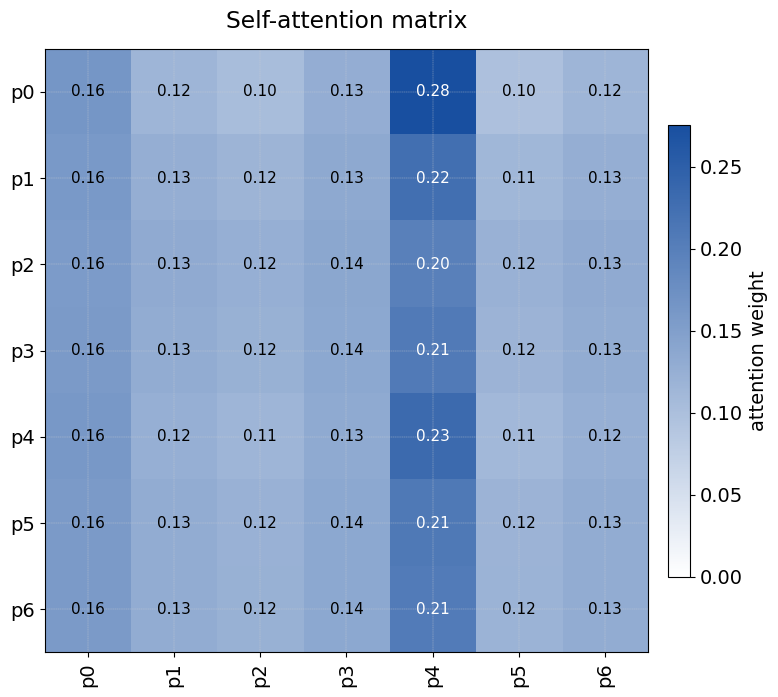

In [6]:
# ------------------------------------------------------------- #
#  Tiny self-attention demo                                     #
# ------------------------------------------------------------- #
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 0) Reproducibility
tf.random.set_seed(0)
np.random.seed(0)

# 1) Synthetic data  (create fresh every run)
VOCAB_SIZE  = 51        # integers 1‒50, plus 0 for [CLS]
BASE_LEN    = 6         # six random tokens
NUM_SAMPLES = 8_000
EPOCHS      = 10

rand_tokens = np.random.randint(1, VOCAB_SIZE, size=(NUM_SAMPLES, BASE_LEN))
tokens_np   = np.concatenate(
                 [np.zeros((NUM_SAMPLES, 1), dtype=int),   # [CLS] = 0
                  rand_tokens],
                 axis=1)                                   # shape (N, 7)

labels_np   = (tokens_np[:, 4] == 42).astype("float32")    # is token-4 == 42?
SEQ_LEN     = tokens_np.shape[1]                          # 7

class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab, d_model, max_len, **kw):
        super().__init__(**kw)
        self.tok = layers.Embedding(vocab,   d_model)
        self.pos = layers.Embedding(max_len, d_model)
    def call(self, tok_ids):
        L = tf.shape(tok_ids)[1]
        return self.tok(tok_ids) + self.pos(tf.range(L))

D_MODEL = 8
inp  = layers.Input((SEQ_LEN,), dtype="int32")
emb  = PositionalEmbedding(VOCAB_SIZE, D_MODEL, SEQ_LEN)(inp)

mha = layers.MultiHeadAttention(
        num_heads=1,
        key_dim=D_MODEL,     
        output_shape=D_MODEL,
        name="self_attn")

attn_out, attn_scores = mha(
        emb,             # query
        emb,             # value  (same, so self-attention)
        return_attention_scores=True)
x        = layers.LayerNormalization(epsilon=1e-6)(emb + attn_out)
cls_vec  = x[:, 0, :]      
logits   = layers.Dense(1, activation="sigmoid")(cls_vec)

model = Model(inp, logits)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

ds = (tf.data.Dataset.from_tensor_slices((tokens_np, labels_np))
        .shuffle(NUM_SAMPLES)
        .batch(32))
model.fit(ds, epochs=EPOCHS, verbose=0)

# Extract attention for the first sample
A = Model(inp, attn_scores).predict(tokens_np[:1], verbose=0)[0, 0]  # (7, 7)

# Plot heat-map
positions = [f"p{i}" for i in range(SEQ_LEN)]
plt.rcParams.update({"font.size": 14})
cmap = LinearSegmentedColormap.from_list("wb", ["#ffffff", "#184fa0"])

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(A, cmap=cmap, vmin=0, vmax=A.max())

ax.set_xticks(range(SEQ_LEN)); ax.set_xticklabels(positions, rotation=90)
ax.set_yticks(range(SEQ_LEN)); ax.set_yticklabels(positions)
ax.set_title("Self-attention matrix", pad=15)

for i in range(SEQ_LEN):
    for j in range(SEQ_LEN):
        val = A[i, j]
        ax.text(j, i, f"{val:.2f}",
                ha="center", va="center",
                color="white" if val > 0.6*A.max() else "black", fontsize=11)

fig.colorbar(im, fraction=0.035, pad=0.03,
             label="attention weight")
ax.grid(which="both", color="lightgray", linewidth=0.25, linestyle="--", zorder=-1)
plt.tight_layout()
plt.show()


In [94]:
print("Sentence-0:", tokens_np[0])
print("Token at pos-3:", tokens_np[0, 3])
pred = model.predict(tokens_np[:1])[0, 0]
print("Model output for sample-0:", pred)   # should be ≪ 0.5

idx = np.where(labels_np == 1)[0][0]   # first positive sample
print(f"Sentence-{idx}:", tokens_np[idx])
print(model.predict(tokens_np[idx:idx+1])[0, 0])  # should be ≫ 0.5

loss, acc = model.evaluate(ds, verbose=0)
print(f"Model accuracy: {acc:.2%}")
print(f"Model loss: {loss:.4f}")
print("Model summary:")
model.summary()


Sentence-0: [ 0 45 48  1  4  4 40]
Token at pos-3: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Model output for sample-0: 0.000100963625
Sentence-103: [ 0 34 13 33 42 17  3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.9992883
Model accuracy: 100.00%
Model loss: 0.0001
Model summary:


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 7, 8)      │        464 │ input_layer_10[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attn           │ [(None, 7, 8),    │        288 │ positional_embed… │
│ (MultiHeadAttentio… │ (None, 1, 7, 7)]  │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 7, 8)      │          0 │ positional_embed… │
│                     │                   │            │ self_attn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 8)      │         16 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_22         │ (None, 8)         │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │          9 │ get_item_22[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,333 (9.12 KB)

 Trainable params: 777 (3.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,556 (6.08 KB)